In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  5 16:25:22 2022

@author: kurt_
"""
# %%
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# %%

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import norm, skew #for some statistics
from scipy import stats

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.tsatools import detrend
from sklearn.model_selection import train_test_split

import os
import platform
op_sys = platform.system()
if op_sys == 'Windows':
    path = 'C:\\Users\\kurt_\\Dropbox\\code\\hp-github\\T-Matrix-Titan\\special\\data\\'
    # path = 'C:\\Users\\kurt_\\Google Drive\\dell_github\\T-Matrix-Titan\\special\\data\\'

elif op_sys == 'Linux':
    path = '/home/cihat/Dropbox/code/special/data/'
os.chdir(path)

In [3]:
# Function for reshaping data after power transformation
def reshape_after_pt(df_pt, df): 
    df_pt = pd.DataFrame(df_pt, columns=
                             df.columns)
    df_pt.index = df.index
    return df_pt

In [4]:
# Reading the coefficients data
df = pd.read_csv(path+'coefficients\\forward\\allregimes.csv')
df = df.drop("Unnamed: 0", axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   N         271 non-null    int64  
 1   xm        271 non-null    float64
 2   nr        271 non-null    float64
 3   ni        271 non-null    float64
 4   taus_out  271 non-null    float64
 5   taua_out  271 non-null    float64
 6   qs_tm     271 non-null    float64
 7   qs_pm     271 non-null    float64
 8   m0        271 non-null    float64
 9   p1        271 non-null    float64
 10  p2        271 non-null    float64
 11  p3        271 non-null    float64
 12  Rf        271 non-null    float64
 13  xm_m0     271 non-null    float64
 14  N_m0      271 non-null    float64
 15  N_xm      271 non-null    float64
dtypes: float64(15), int64(1)
memory usage: 34.0 KB


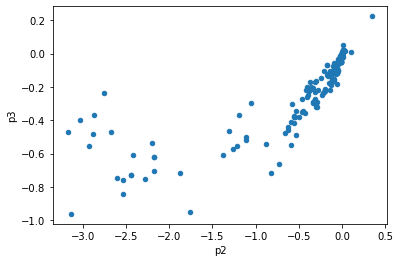

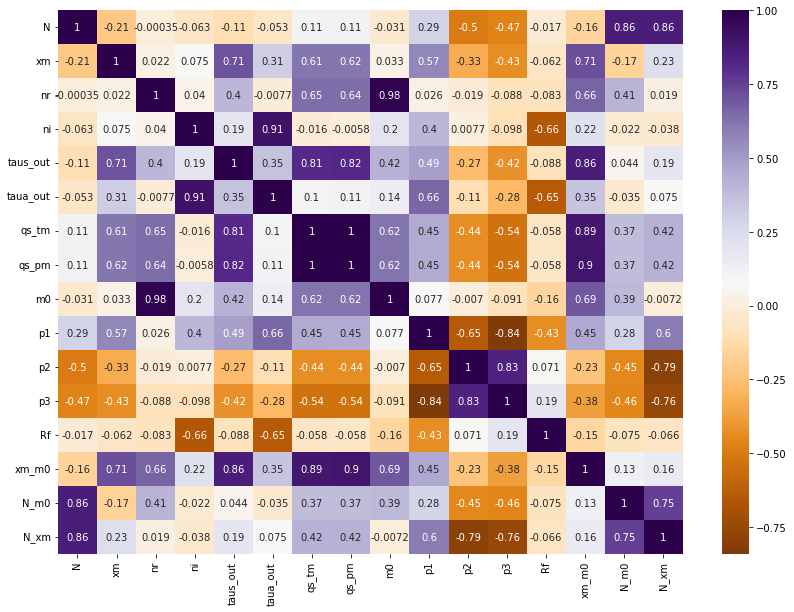

In [5]:
# print(df.head())
df.plot(x='p2', y='p3', kind='scatter')
# Coefficients depend on each other as expected, not not strongly though.
# Above plotting shows that.
# If synthetic data will be created we should create p1,p2,p3 all together.
# let's plot pairwise correlation heatmap
f, ax = plt.subplots(figsize=(14, 10))
ax = sns.heatmap(df.corr(), annot=True, cmap='PuOr')
plt.show()

## Train / Test Split
Let's do the modelling for N>=256. For N<=256 aeroscat already works perfectly.

In [6]:
#filtering out N<256
df = df.query('N >= 256')
# Let's do our feature selection.
# Make a variable called 'features', and a list containing the strings of every column except "p1","p2" or "p3"
features = list(df.drop(['p1','p2', 'p3','qs_pm','qs_tm'], axis=1))
X = df[features]
# For multivariate analysis with multiple dependent vars let's collect all three coefficeints in y
y = df[['p1','p2', 'p3']]
# For individiual separate them as y1, y2 and y3
y1 = y.p1
y2 = y.p2
y3 = y.p3

Let's create the quadratic and non-linear terms for the features. For some variables quadratic terms may be neceassary. See example below.

<AxesSubplot:xlabel='xm', ylabel='p1'>

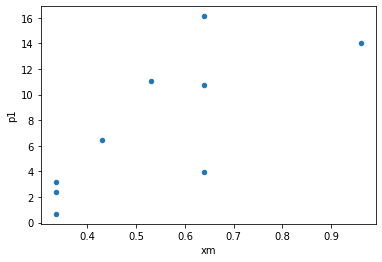

In [7]:
df_256 = df.query('N >= 128 & nr == 2.0 & ni == 0.09')
df_256.plot(x='xm', y='p1', kind='scatter')

C:\Users\kurt_\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='N_xm', ylabel='p1'>

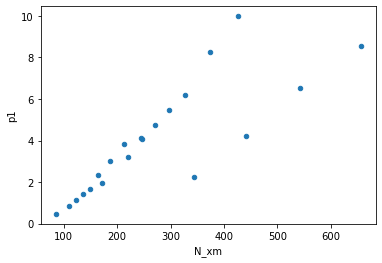

In [8]:
df_064 = df.query(' N >= 128 & nr == 2.0 & ni == 0.023')
df_064.loc[:,'lg2N'] = np.sqrt(df_064['N'])
df_064.plot(x='N_xm', y='p1', kind='scatter')

<AxesSubplot:xlabel='NXmM0', ylabel='p1'>

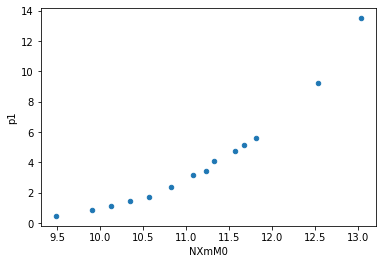

In [9]:
df_064 = df.query(' N >= 128 & xm >=0.03 & nr == 1.8 & ni == 0.023')
df_064.loc[:,'NXmM0'] = np.log2(df['N']) + np.log2(df['N'])*df['xm']*df['m0'] + df['xm']
df_064.plot(x='NXmM0', y='p1', kind='scatter')

#### Non-Linear Terms

Some Domain specific non-linear variables already  exist in the feature like taus_out. Let's also define another variable, Ragg which is a measure of the overall size of the aggregate. 

In [10]:
Ragg = X['xm']*X['N']**(1.0/3)
X.loc[:,'Ragg'] = Ragg
# Now we can drop the N*xm term from the features
X = X.drop(['N_xm'], axis=1)

In [11]:
# Creating quadratic terms
# Let's exclude the combionation terms as their quadratic terms might cause too
# much complexity. 
comb_terms = ['xm_m0', 'N_m0']
for i in X:
    if i not in comb_terms:
        X.loc[:,f'{i}_sqr'] = X[i]**2

X.columns

Index(['N', 'xm', 'nr', 'ni', 'taus_out', 'taua_out', 'm0', 'Rf', 'xm_m0',
       'N_m0', 'Ragg', 'N_sqr', 'xm_sqr', 'nr_sqr', 'ni_sqr', 'taus_out_sqr',
       'taua_out_sqr', 'm0_sqr', 'Rf_sqr', 'Ragg_sqr'],
      dtype='object')

In [12]:
# Add combination term for N*xm*m0 but before convert N to log2 as every single monomer has a pair
# Thus N is always in the form of 2**n where n is an integer. 
# X.loc[:, 'N'] = np.log2(X['N'])
X.loc[:, 'N'] = X['N']**-0.5
X['N_xm_m0'] = df.N*df['xm']*df['m0']
X.columns

Index(['N', 'xm', 'nr', 'ni', 'taus_out', 'taua_out', 'm0', 'Rf', 'xm_m0',
       'N_m0', 'Ragg', 'N_sqr', 'xm_sqr', 'nr_sqr', 'ni_sqr', 'taus_out_sqr',
       'taua_out_sqr', 'm0_sqr', 'Rf_sqr', 'Ragg_sqr', 'N_xm_m0'],
      dtype='object')

In [13]:
lin_features = ['N', 'xm', 'm0', 'taus_out', 'taua_out', 'Ragg']
X_ = X[lin_features]

In [14]:
# First create the quadratic terms
quadratic_terms = []
for i in X_:
    X_.loc[:,f'{i}**2'] = X_[i]**2
    quadratic_terms.append(f'{i}**2')
# Then create combination terms including the quadratic combinations
columns = X_.columns
for i in columns:
    for j in columns:
        if f'{j}*{i}' in X_.columns:
            continue
        elif i == j:
            continue
        elif i in quadratic_terms and j in quadratic_terms:
            continue # don't include combination of two quadratic terms
        else:
            X_.loc[:,f'{i}*{j}'] = X_[i]*X_[j]

In [15]:
X_['N_xm_m0'] = np.log2(df.N)*df['xm']*df['m0']

In [16]:
y.head()

,p1,p2,p3
0,1.862510,-0.094391,-0.100302
1,1.920963,-0.094644,-0.101012
2,2.235463,-0.096444,-0.104801
3,2.619269,-0.098279,-0.109489
4,3.382607,-0.102374,-0.118739


In [17]:
# Call train_test_split on X, y. Make the test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X_, y, 
                                                    test_size=0.25)

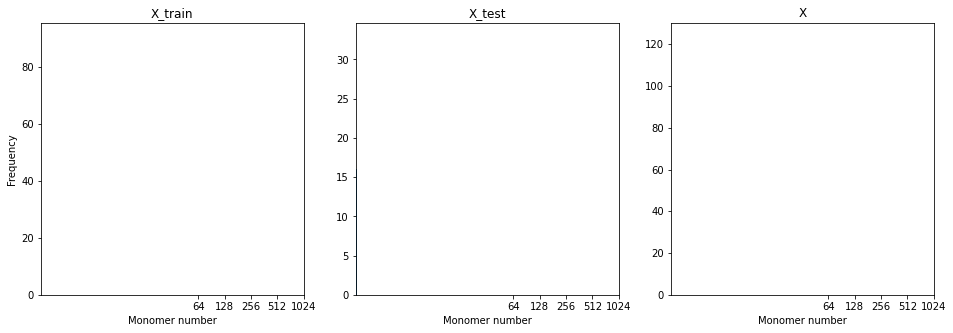

In [248]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
ax[0].hist(X_train.N)
ax[0].set_xticks([6,7,8,9,10])
ax[0].set_xticklabels(['64','128','256','512','1024'])
ax[0].set_title('X_train')
ax[0].set_ylabel('Frequency')

# plotting X_test
ax[1].hist(X_test.N)
ax[1].set_xticks([6,7,8,9,10])
ax[1].set_xticklabels(['64','128','256','512','1024'])
ax[1].set_title('X_test')

# Plotting overall data 
# plotting X_test
ax[2].hist(X.N)
ax[2].set_xticks([6,7,8,9,10])
ax[2].set_xticklabels(['64','128','256','512','1024'])
ax[2].set_title('X')

# Set x labels
for axes in ax:
    axes.set_xlabel("Monomer number")

# plt.show()

**This is a resonable splitting considering the available distritbution.**

### Checking Normality of the Variables.
Regression models assume that the variables are normally distributed. Therefore the following steps will be applied to check for distribution of the variables and transform those with high skeweness and kurtosis distributions:

Do skewness test for each columns.

Consider those with absolute value of skewness > 0.5 as skewed the rest as acceptable

Apply box-cox transformation

In [18]:
# Skewness test
skewed = X_train.skew().sort_values(ascending=False)
print('X_train before transformation')
pd.DataFrame({'skewness': skewed})

X_train before transformation


,skewness
taus_out*taua_out**2,10.791138
taua_out*taua_out**2,7.840228
xm*taua_out**2,7.571114
Ragg*taua_out**2,7.533102
taus_out*taua_out,7.046048
...,...
N*m0,0.085403
m0,-0.299381
N*N**2,-0.355382
N**2,-0.452926


Several variables are skewed. We can fix the skewness by applying power transformation to variables including the response variable.

In [19]:
# Apply yeo-johnson power transformation which is unlike box-cox method allows negative values
pt = PowerTransformer(method='yeo-johnson', standardize=True)
Xpt = pt.fit_transform(X_train)

X_train = reshape_after_pt(Xpt, X_train)
pd.DataFrame(X_train.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
taua_out*taua_out**2,2.794575
taus_out*taus_out**2,2.138366
taus_out*taua_out**2,2.075147
N*taua_out**2,1.703264
xm*taua_out**2,1.677355
...,...
Ragg*Ragg**2,-0.047018
m0,-0.084043
N*N**2,-0.279513
N**2,-0.307254


In [20]:
# Now transform the test set using the transformer trained by training set
Xpt = pt.transform(X_test)
X_test = reshape_after_pt(Xpt, X_test)
pd.DataFrame(X_test.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
taua_out*taua_out**2,2.609560
taus_out*taua_out**2,2.223584
xm*taua_out**2,2.021518
N*taua_out**2,1.944866
taua_out**2,1.869049
...,...
xm*Ragg**2,-0.375970
N*N**2,-0.387198
N**2,-0.414861
m0,-0.431423


In [21]:
# Skewness test for y_train
skewed = y_train.skew().sort_values(ascending=False)
print('y_train before transformation')
pd.DataFrame({'skewness': skewed})

y_train before transformation


,skewness
p1,2.302982
p3,-1.463598
p2,-2.537648


In [22]:
# Apply yeo-johnson power transformation which is unlike box-cox method allows negative values
pt = PowerTransformer(method='yeo-johnson', standardize=True)
ypt = pt.fit_transform(y_train)

y_train = reshape_after_pt(ypt, y_train)
pd.DataFrame(y_train.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
p3,0.035383
p2,0.024968
p1,0.024175


In [23]:
# Now transform the test set using the transformer trained by training set
ypt = pt.transform(y_test)
y_test = reshape_after_pt(ypt, y_test)
pd.DataFrame(y_test.skew().sort_values(ascending=False), columns=['skewness'])

,skewness
p1,0.128298
p3,-0.490256
p2,-0.596718


# Feature Selection
1. Lasso regression to select the features.
Use cross validation for hyper-parameter tunning
2. Use XGboost, Lgbm boost, and deep learning model. If test results are not great then use data augmentation by creating synthetic data.

In [24]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

def rmse_cv(model,Y):
    rmse= np.sqrt(-cross_val_score(model, X_train, Y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [256]:
model_ridge = Ridge()

In [90]:
alphas = [ x for x in np.arange(0.01,2,0.02)]
cv_ridge = [rmse_cv(Ridge(alpha = alpha),y_train.p1).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

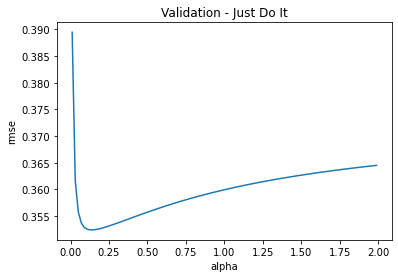

In [91]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [92]:
alpha_ridge = pd.Series(cv_ridge, index = alphas).idxmin()
print(f'Alpha for Ridge: {alpha_ridge}, the rmse for ridge:{cv_ridge.min()}')

Alpha for Ridge: 0.12999999999999998, the rmse for ridge:0.3524209151325042


In [93]:
model_ridge = Ridge(alpha=0.13).fit(X_train, y_train.p1)

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

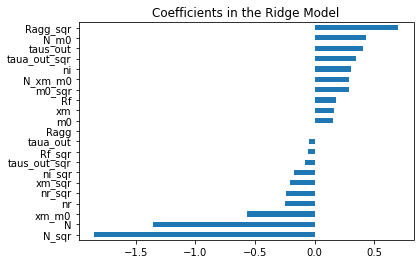

In [94]:
imp_coef = pd.Series(model_ridge.coef_, index = X_train.columns).sort_values()
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

RMSE: 0.254812252377849
Alpha for Lasso: 0.001


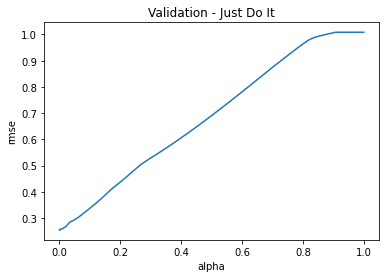

In [28]:
model_lasso = Lasso()
alphas = [ x for x in np.arange(1e-3,1, 5e-4)]
# alphas =  [1e-4, 5e-4, 1e-3, 2e-3, 3e-3, 4e-3,1e-4]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=1000000),y_train.p1).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
print(f'RMSE: {cv_lasso.min()}')
print(f'Alpha for Lasso: {pd.Series(cv_lasso, index = alphas).idxmin()}')

C:\Users\kurt_\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e+00, tolerance: 1.256e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\kurt_\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+00, tolerance: 1.380e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\Users\kurt_\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

RMSE: 0.25327603245475494
Alpha for Lasso: 0.00021


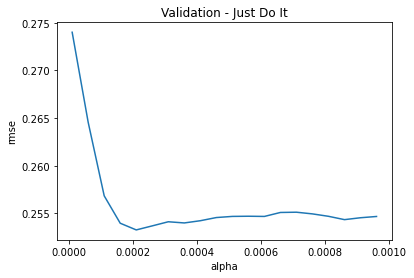

In [27]:
model_lasso = Lasso()
alphas = [ x for x in np.arange(1e-5,1e-3, 5e-5)]
# alphas =  [1e-4, 5e-4, 1e-3, 2e-3, 3e-3, 4e-3,1e-4]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, max_iter=1000000),y_train.p1).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
print(f'RMSE: {cv_lasso.min()}')
print(f'Alpha for Lasso: {pd.Series(cv_lasso, index = alphas).idxmin()}')

Now fit the Lasso with the best alpha for feature selection

In [37]:
model_lasso = Lasso(alpha = 0.0055, max_iter = 300000).fit(X_train, y_train.p1) # 0.0055 was very simple and lowest rmse ever without triple comb term

In [40]:
rmse= np.sqrt(-cross_val_score(model_lasso, X_train, y_train.p1, scoring="neg_mean_squared_error", cv = 5))
rmse.mean()

0.2577779344238066

Plotting the feature importance from Lasso 

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

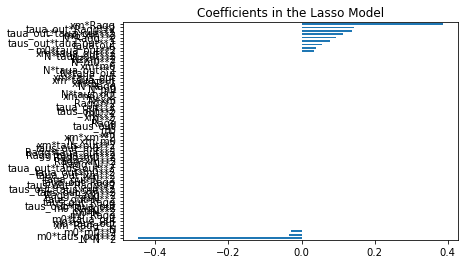

In [34]:
imp_coef = pd.Series(model_lasso.coef_, index = X_train.columns).sort_values()
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [48]:
mask = abs(imp_coef) <= 0.05
imp_coef[mask]

m0*taus_out**2         -0.033803
m0*m0**2               -0.029330
N                      -0.000000
xm*Ragg**2              0.000000
m0*taus_out            -0.000000
m0*taua_out             0.000000
m0*Ragg                 0.000000
m0*N**2                -0.000000
m0*Ragg**2              0.000000
taus_out*taua_out       0.000000
taus_out*Ragg           0.000000
taus_out*N**2           0.000000
Ragg*Ragg**2            0.000000
taus_out*xm**2          0.000000
taus_out*taus_out**2   -0.000000
taus_out*Ragg**2        0.000000
taua_out*Ragg           0.000000
taua_out*N**2           0.000000
taua_out*xm**2          0.000000
taua_out*m0**2          0.000000
taua_out*taus_out**2   -0.000000
Ragg*N**2               0.000000
Ragg*xm**2              0.000000
Ragg*m0**2             -0.000000
Ragg*taus_out**2       -0.000000
Ragg*taua_out**2        0.000000
taus_out*m0**2         -0.000000
xm*taus_out**2          0.000000
N_xm_m0                 0.000000
xm*xm**2                0.000000
xm        

Re-define the features

In [49]:
features = imp_coef[~mask].index.to_list()
features.append('N')
features.append('m0')
X_ = X_train[features]
X_

,N*N**2,taua_out,taus_out*taua_out**2,N*Ragg**2,m0*xm**2,taua_out*taua_out**2,taua_out*Ragg**2,xm*Ragg,N,m0
114,0.884352,0.675419,-0.187096,-0.027486,0.135355,-0.163174,0.293134,-0.133172,0.875222,0.044077
127,0.884352,2.172924,3.035497,0.296711,0.198564,3.886275,1.750374,0.183958,0.875222,-0.440132
1,-1.380223,-1.381668,-0.590414,-1.231699,-1.619405,-0.481858,-1.311281,-1.040026,-1.515424,-1.507009
76,0.884352,-0.577431,-0.585477,-1.479278,-1.170484,-0.470421,-1.117433,-1.578128,0.875222,0.033023
3,-1.380223,-0.150627,-0.586781,-1.231699,-1.614117,-0.437702,-0.434622,-1.040026,-1.515424,-1.492225
...,...,...,...,...,...,...,...,...,...,...
19,-1.380223,1.356581,-0.346819,0.054898,-0.943040,0.833196,1.411337,0.324648,-1.515424,-1.448136
173,0.884352,0.234161,0.699754,1.674147,1.709728,-0.363813,0.929331,1.593529,0.875222,0.027265
207,-0.992305,-1.442715,-0.590255,-0.288988,-0.313148,-0.481883,-1.329007,-0.211262,-0.913313,-0.054120
101,0.884352,-0.297041,-0.531179,-0.476192,-0.130482,-0.452915,-0.616529,-0.571574,0.875222,0.460107


Split Data again by test/train

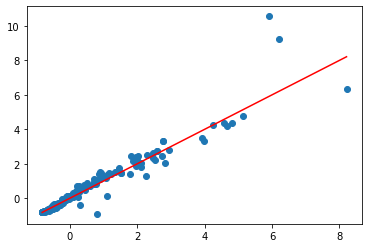

In [41]:
# This is a good way to see how model predict data
p_pred = np.expm1(model_lasso.predict(X_train))
plt.scatter(p_pred, np.expm1(y_train.p1))
plt.plot([min(p_pred),max(p_pred)], [min(p_pred),max(p_pred)], c="red")

In [43]:
# Call train_test_split on X, y. Make the test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X_, y, 
                                                    test_size=0.25)

ValueError: Found input variables with inconsistent numbers of samples: [165, 220]

In [36]:
import pickle
data = [X_train, X_test, y_train, y_test, Xpt, ypt]
with open('./coefficients\\forward\\data_and_pt.pkl', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)


In [37]:
# with open('./coefficients\\forward\\data_and_pt.pkl', 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     data = pickle.load(f)

# Modelling

In [39]:
y1_train = y_train.p1
y1_test = y_test.p1